<a href="https://colab.research.google.com/github/kszymon/Neural-Network-Pytorch/blob/main/regresja_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
from torch import nn as nn
import torch.nn.functional as F
import numpy as np
import csv
import pandas as pd
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import cm

In [57]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
num_of_devices = torch.cuda.device_count()
print(f'num of devices {num_of_devices}')
if torch.cuda.is_available():
  print(f'device name is {torch.cuda.get_device_name()}')

num of devices 0


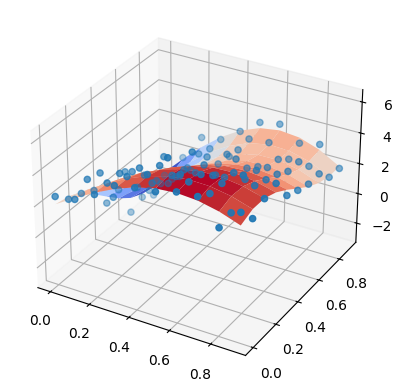

In [58]:
# generacja danych

fun = lambda x, y: 2*np.sin(2.8*x*y) + 3* np.sin(2.6*x) + 2 * np.cos(4.1*y)
lb = 0
ub = 1
xx = np.arange(lb, ub, 1e-1)
xx, yy = np.meshgrid(xx, xx)

ff = fun(xx, yy)

#plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, ff, cmap=cm.coolwarm)

ax.scatter(xx, yy, ff + 0.5 * np.random.randn(*ff.shape))

In [59]:
def generate_data(fun, noise_amp, num_of_data):
  mat = np.zeros((num_of_data, 3))
  for i in range((num_of_data)):
    x, y = np.random.randn(2)
    f = fun(x, y) + noise_amp * np.random.randn()
    mat[i, 0] = x
    mat[i, 1] = y
    mat[i, 2] = f
  return mat

In [60]:
data_array = generate_data(fun, 0.5, 10000)

#headers
headers = ['x_value', 'y_value', 'fun_value']

import os
os.makedirs('data', exist_ok=True)

with open('data/data.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(headers)
  for i in range(data_array.shape[0]):
    writer.writerow(data_array[i, :])

In [61]:
# wczytanie z Pandas

df = pd.read_csv('data/data.csv')
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,x_value,y_value,fun_value
0,0.638740,-0.394778,2.052706
1,0.635927,-1.609352,3.952286
2,-0.521561,1.431693,-3.486353
3,0.115161,0.945528,0.201311
4,1.515882,-2.088384,-4.674371


In [62]:
data_row = df.iloc(1)
print(df.iloc[1])

x_value      0.635927
y_value     -1.609352
fun_value    3.952286
Name: 1, dtype: float64


In [63]:
# wyznaczanie mu i std
arr = np.array(df)
print(arr.shape)

data_mu = np.mean(arr, axis=0)
data_std = np.std(arr, axis=0)

print(f'mu is {data_mu} and std is{data_std}')

(10000, 3)
mu is [-0.00748006 -0.00513657  0.06038482] and std is[0.99465714 0.99623599 2.89522112]


In [64]:
# create dataloader
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, csv_file, transform=True):
      super().__init__()

      self.data_df = pd.read_csv(csv_file)
      self.data_array = np.array(self.data_df)

      self.transform = transform
      self.data_std = np.std(self.data_array, axis=0)
      self.data_mu = np.mean(self.data_array, axis=0)

    def __len__(self):
      return len(self.data_array)

    def __getitem__(self, idx):
      data = self.data_array[idx, 0:-1]
      target = self.data_array[idx, -1]

      if self.transform:
        # normalizacja do [0, 1]
        target = (target - np.min(self.data_array[:, -1])) \
        / (np.max(self.data_array[:, -1]) - np.min(self.data_array[:, -1]))

      return (torch.tensor(data, dtype=torch.float32).to(device),
              torch.tensor(target, dtype=torch.float32).to(device))

In [65]:
dataset = MyDataset('data/data.csv')

In [66]:
print(next(iter(dataset)))
print(len(dataset))

(tensor([ 0.6387, -0.3948]), tensor(0.6392))
10000


In [67]:
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.7 * len(dataset)), int(0.3 * len(dataset))])

In [68]:
# tworze data loader'y
train_loader = DataLoader(train_set, batch_size= 10, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=10, shuffle=True)

In [69]:
# test data loaderow

loader_output = next(iter(train_loader))

print(f'shape of output data {loader_output[0].shape}')
print(f'shape of output targets {loader_output[1].shape}')

shape of output data torch.Size([10, 2])
shape of output targets torch.Size([10])


In [93]:
from IPython.core.display import set_matplotlib_formats
# implementacja sieci neunowych

class Regressor(nn.Module):
  def __init__(self, input_feature):
    super().__init__()

    self.first_layer = nn.Linear(in_features=input_feature, out_features=128)
    self.second_layer = nn.Linear(in_features=128, out_features=128)
    self.mid1 = nn.Linear(in_features=128, out_features=128)
    self.mid2 = nn.Linear(in_features=128, out_features=128)

    self.last_layer = nn.Linear(in_features=128, out_features=1)
    # aktywacja
    self.activate = F.relu
    self.loss = F.mse_loss

    # regularyzacja
    self.reg_drop = nn.Dropout(p=0.5)

  def forward(self, x):

    x = self.first_layer(x)
    x = self.activate(x)

    x = self.second_layer(x)
    x = self.activate(x)
    # reg
    x = self.reg_drop(x)
    x = self.mid1(x)
    x = self.activate(x)
    # reg
    x = self.reg_drop(x)
    x = self.mid2(x)
    x = self.activate(x)

    return self.last_layer(x)

In [94]:
model = Regressor(input_feature=2)

if torch.cuda.is_available():
  torch.cuda.set_device(device)
  model.cuda()

data_batch = next(iter(train_loader))
y = model(data_batch[0])
print(f'shape of y is {y.shape}')

shape of y is torch.Size([10, 1])


In [95]:
# funkcja testujace
def test_model(trained_model, is_regularize, test_loader, l2_lambda):

  trained_model.eval()
  test_related_error = []
  test_losses = []

  with torch.no_grad():
    for batch_ind, (data, targets) in enumerate(test_loader):

      y = torch.squeeze(trained_model(data), dim=1)
      # targets = torch.squeeze(targets, dim=1) # This line is removed
      if is_regularize:
        l2_norm = sum(p.pow(2.0).sum() for p in trained_model.parameters())
        loss = trained_model.loss(y, targets) + l2_lambda * l2_norm
      else:
        loss = trained_model.loss(y, targets)

      ls = loss.item()
      test_losses.append(ls)

      test_related_error.append(torch.mean((targets - y) / targets).cpu())

  tre = torch.tensor(np.array(test_related_error))
  test_loss = torch.mean(torch.tensor(np.array(test_losses)))

  return test_loss, torch.mean(tre)

In [100]:
# petla treningowa
from tqdm import tqdm
num_of_epochs = 30
reg = False

l2_lambda = 0.001
lr = 0.00005

model = Regressor(input_feature=2)

if torch.cuda.is_available():
  model.cuda()

# optymalizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

test_relative_error = []
train_losses = []
test_losses = []

for epoch in tqdm(range(num_of_epochs), desc='train porgress'):
  model.train()

  epoch_losses = []
  for batch_index, (data, targets) in enumerate(train_loader):
    predictions = torch.squeeze(model(data), dim=1)
    if reg:
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
      loss = model.loss(predictions, targets) + l2_lambda * l2_norm

    else:
      loss = model.loss(predictions, targets)

    epoch_losses.append(loss.item())

    # krok optymalizacji
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  test_loss, test_rel_err = test_model(model,
                                       is_regularize=reg,
                                       test_loader=test_loader,
                                       l2_lambda=l2_lambda)
  # save losses
  averaged_loss = np.mean(epoch_losses)
  train_losses.append(averaged_loss)
  test_losses.append(test_loss)
  test_relative_error.append(test_rel_err)

  print(f'train loss {averaged_loss}, test_loss {test_loss}')

train porgress:   3%|▎         | 1/30 [00:02<01:19,  2.73s/it]

train loss 0.10600609029776284, test_loss 0.037797110754375654


train porgress:   7%|▋         | 2/30 [00:05<01:25,  3.04s/it]

train loss 0.04288911902611809, test_loss 0.030201397651496032


train porgress:  10%|█         | 3/30 [00:08<01:16,  2.84s/it]

train loss 0.03412720461309488, test_loss 0.02684150212754806


train porgress:  13%|█▎        | 4/30 [00:11<01:10,  2.72s/it]

train loss 0.029494598401111682, test_loss 0.025131782623939215


train porgress:  17%|█▋        | 5/30 [00:13<01:07,  2.69s/it]

train loss 0.026131698013549403, test_loss 0.022891785791919878


train porgress:  20%|██        | 6/30 [00:17<01:09,  2.90s/it]

train loss 0.02309178063213559, test_loss 0.019902627138265717


train porgress:  23%|██▎       | 7/30 [00:20<01:07,  2.92s/it]

train loss 0.02168752834633259, test_loss 0.020891126077622175


train porgress:  27%|██▋       | 8/30 [00:22<01:02,  2.85s/it]

train loss 0.019933118312120704, test_loss 0.016799610411205017


train porgress:  30%|███       | 9/30 [00:25<00:59,  2.83s/it]

train loss 0.018499881211734775, test_loss 0.015140991746447981


train porgress:  33%|███▎      | 10/30 [00:28<00:56,  2.85s/it]

train loss 0.017506555556319654, test_loss 0.014361446743132547


train porgress:  37%|███▋      | 11/30 [00:31<00:57,  3.01s/it]

train loss 0.01678898021079866, test_loss 0.01380809761545


train porgress:  40%|████      | 12/30 [00:34<00:52,  2.93s/it]

train loss 0.016046117773013454, test_loss 0.013312804116867482


train porgress:  43%|████▎     | 13/30 [00:37<00:48,  2.86s/it]

train loss 0.014960373287820922, test_loss 0.013066476783715189


train porgress:  47%|████▋     | 14/30 [00:39<00:44,  2.80s/it]

train loss 0.014839156456956906, test_loss 0.012544156601652503


train porgress:  50%|█████     | 15/30 [00:43<00:46,  3.07s/it]

train loss 0.013431278084837166, test_loss 0.01137996898808827


train porgress:  53%|█████▎    | 16/30 [00:46<00:41,  2.96s/it]

train loss 0.01279575774778745, test_loss 0.010731741023482755


train porgress:  57%|█████▋    | 17/30 [00:49<00:37,  2.91s/it]

train loss 0.012331549991254827, test_loss 0.010870205904745186


train porgress:  60%|██████    | 18/30 [00:51<00:34,  2.85s/it]

train loss 0.01175860870496503, test_loss 0.009291411149703587


train porgress:  63%|██████▎   | 19/30 [00:55<00:32,  2.99s/it]

train loss 0.011176920875274976, test_loss 0.008884338475763798


train porgress:  67%|██████▋   | 20/30 [00:58<00:29,  2.99s/it]

train loss 0.011011236395320988, test_loss 0.008636752770786795


train porgress:  70%|███████   | 21/30 [01:00<00:26,  2.91s/it]

train loss 0.010402869639053408, test_loss 0.007902599920635111


train porgress:  73%|███████▎  | 22/30 [01:03<00:22,  2.84s/it]

train loss 0.010111452444855656, test_loss 0.008379562416036303


train porgress:  77%|███████▋  | 23/30 [01:06<00:19,  2.80s/it]

train loss 0.00953830654732883, test_loss 0.007900062233093195


train porgress:  80%|████████  | 24/30 [01:09<00:18,  3.03s/it]

train loss 0.009204015105996015, test_loss 0.008300152528293742


train porgress:  83%|████████▎ | 25/30 [01:12<00:14,  2.92s/it]

train loss 0.008989159107773698, test_loss 0.007996315422157447


train porgress:  87%|████████▋ | 26/30 [01:15<00:11,  2.89s/it]

train loss 0.008685293942107819, test_loss 0.006520590896252542


train porgress:  90%|█████████ | 27/30 [01:17<00:08,  2.83s/it]

train loss 0.008441558387213654, test_loss 0.007114340077581194


train porgress:  93%|█████████▎| 28/30 [01:21<00:06,  3.09s/it]

train loss 0.008026638306910172, test_loss 0.006749766213470138


train porgress:  97%|█████████▋| 29/30 [01:24<00:02,  2.99s/it]

train loss 0.008065788055869884, test_loss 0.006414949045671771


train porgress: 100%|██████████| 30/30 [01:27<00:00,  2.90s/it]

train loss 0.007570675676522244, test_loss 0.00594327455405922


Text(0.5, 1.0, ' MSE - loss, l2 reqularization is False')

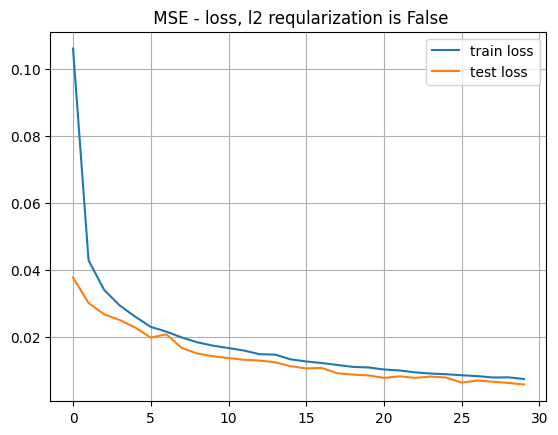

In [101]:
# wykres loss'u

x = np.arange(0, len(train_losses))
plt.plot(x, train_losses, label='train loss')
plt.plot(x, test_losses, label='test loss')
plt.grid()
plt.legend()
plt.title(f' MSE - loss, l2 reqularization is {reg}')